In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation # animation
import imageio 

import fiona
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape
import os

In [63]:
#get information from the shp file, without creating the output tif files
#CAREFULL! THE INDEX HERE IS DIFFERENT FROM THE ONES ON THE OTHER FILES, 
#SINCE THE SHP FILE WE ARE USING IS NOT THE SAME: 2 GLACEIRS ARE HERE MISSING

path_to_tif = '/Users/francesco/Desktop/Data/CALVIN/'
shapefile_path = '/Users/francesco/Desktop/Thesis/Data/iceshelf_flux_greene.gpkg'

ids = []
id_measures = []
Names = []
Names_1 = []
ice_calving_time_series_shp = []
ice_calving_time_series_shp_sd = []
boundaries = []

years = np.arange(2000,2022,1)

shapefile=fiona.open(shapefile_path)
print(shapefile.schema['properties'])


for feature in shapefile:

    id = feature['id']
    id_measure = feature['properties']['id_measures']
    name=feature['properties']['measures_name']
    name_1 = feature['properties']['ice_shelf_name']
    geometry=feature['geometry']
    if geometry is None:
        print('No geometry for this feature' + str(id_measure))
        continue 
    bounds=shape(geometry).bounds
    xmin=bounds[0];ymin=bounds[1];xmax=bounds[2];ymax=bounds[3]
    bounds_temp = [xmin,ymin,xmax,ymax]
 

    #print(id,name,geometry)

    ids.append(id)
    Names.append(name)
    ice_calvinng_temp_glacier = []
    ice_calvinng_temp_glacier_sd = []
    boundaries.append(bounds_temp)
    Names_1.append(name_1)
    id_measures.append(id_measure)

    for year in years:
        ice_calving_temp_year = feature['properties']['mass_change_'+str(year)]
        ice_calving_temp_year_sd = feature['properties']['mass_change_'+str(year)+'_sd']


        ice_calvinng_temp_glacier.append(ice_calving_temp_year)
        ice_calvinng_temp_glacier_sd.append(ice_calving_temp_year_sd)

    ice_calving_time_series_shp.append(ice_calvinng_temp_glacier)
    ice_calving_time_series_shp_sd.append(ice_calvinng_temp_glacier_sd)

{'id_measures': 'int', 'index': 'int', 'ice_shelf_name': 'str:50', 'measures_name': 'str:50', 'latitude': 'float', 'longitude': 'float', 'thickness_trend_97_17_obs': 'float', 'thickness_trend_97_17_sd': 'float', 'smb_mean_97_17_obs': 'float', 'smb_mean_97_17_sd': 'float', 'ss_gl_flux_obs': 'float', 'ss_gl_flux_sd': 'float', 'ss_calving_flux_obs': 'float', 'ss_calving_flux_sd': 'float', 'model_gl_flux_control': 'float', 'instant_collapse_flux': 'float', 'mass_change_97': 'float', 'mass_change_97_sd': 'float', 'mass_change_2000': 'float', 'mass_change_2000_sd': 'float', 'mass_change_2000_75': 'float', 'mass_change_2000_75_sd': 'float', 'mass_change_2001': 'float', 'mass_change_2001_sd': 'float', 'mass_change_2002': 'float', 'mass_change_2002_sd': 'float', 'mass_change_2003': 'float', 'mass_change_2003_sd': 'float', 'mass_change_2004': 'float', 'mass_change_2004_sd': 'float', 'mass_change_2005': 'float', 'mass_change_2005_sd': 'float', 'mass_change_2006': 'float', 'mass_change_2006_sd': '

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



In [64]:
print(id_measures)

[110, 111, 105, 106, 107, 108, 109, 148, 174, 115, 144, 133, 94, 124, 80, 46, 138, 118, 119, 49, 176, 36, 78, 128, 76, 139, 18, 177, 113, 99, 90, 54, 57, 23, 1, 145, 32, 114, 58, 143, 73, 17, 39, 173, 126, 130, 155, 35, 121, 147, 81, 21, 153, 172, 28, 160, 140, 170, 77, 45, 60, 61, 59, 29, 69, 165, 75, 168, 178, 101, 156, 166, 146, 19, 22, 62, 167, 135, 4, 125, 137, 63, 154, 51, 8, 6, 5, 161, 7, 33, 112, 120, 31, 27, 132, 134, 127, 83, 149, 88, 26, 142, 48, 91, 96, 157, 85, 117, 13, 64, 162, 122, 87, 72, 129, 141, 169, 2, 55, 14, 95, 158, 104, 38, 136, 12, 86, 67, 37, 34, 171, 71, 70, 20, 180, 181, 150, 100, 10, 11, 89, 30, 103, 52, 65, 131, 163, 66, 9, 175, 56, 79, 98, 24, 84, 25, 116, 53, 47, 123, 159, 97, 164, 3, 92, 102, 152, 50, 151, 16, 68, 42, 40, 44, 43, 41, 82, 93, 15]


In [65]:
unique_vals, counts = np.unique(id_measures, return_counts=True)
if np.any(counts > 1):
    print("There are repeated values in the array.")
else:
    print("All values in the array are unique.")

All values in the array are unique.


In [66]:
print(np.shape(id_measures))

(179,)


In [8]:

#Here I create the tif files for each shelves for each year (11 mins)


path_to_tif = '/Users/francesco/Desktop/Thesis/Data/CALVING/'
shapefile_path = '/Users/francesco/Desktop/Thesis/Data/iceshelf_flux_greene.gpkg'
#shapefile_path = '/Users/francesco/Desktop/Thesis/Data/ice_shelf.shp'

''' 
for year in years:

    #identifying the geotif file in GEOTIFFs directory
    file_tif = path_to_tif + 'FluxGreen' + str(year) + '.tif'
    print(year)

    shapefile=fiona.open(shapefile_path)

    for feature in shapefile:


        id = feature['id']
        geometry=feature['geometry']
        id_measure = feature['properties']['id_measures']

        if geometry is None:
            continue  # skip this feature if geometry is missing
        bounds=shape(geometry).bounds

        xmin=bounds[0];ymin=bounds[1];xmax=bounds[2];ymax=bounds[3]

        output_file = '/Users/francesco/Desktop/Data_exploration/TIF_Generated_ice_calving/' + str(id_measure) + '_' + str(year) + '.tif'

        # the next command line is saving all the geotiff files in the directory.        
        os.system('gdalwarp -t_srs EPSG:3031 -te '+str(xmin)+' '+str(ymin)+' '+str(xmax)+' '+str(ymax)+' '+file_tif+' '+ output_file)
'''


2000
Creating output file that is 230P x 964L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 39P x 55L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 44P x 63L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 66P x 42L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 74P x 37L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 65P x 81L.
Processing /Users/francesco/Desktop/Th

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 31P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2000.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 291P x 266L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 31P x 17L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2001.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2001.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2001.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2001.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2001.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2001.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2001.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2001.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2001.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2001.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 291P x 266L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2002.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2002.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2002.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2002.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2002.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 31P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2002.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2002.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2002.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2002.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2002.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 291P x 266L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 31P x 17L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2003.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2003.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2003.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2003.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2003.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2003.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2003.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2003.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2003.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2003.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 291P x 266L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2004.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2004.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2004.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2004.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2004.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 31P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2004.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2004.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2004.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2004.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2004.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 291P x 266L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 31P x 17L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2005.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2005.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2005.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2005.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2005.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2005.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2005.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2005.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2005.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2005.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 291P x 266L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 31P x 17L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2006.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2006.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2006.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2006.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2006.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 440P x 548L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2006.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2006.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2006.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2006.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2006.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 31P x 17L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2007.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2007.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2007.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2007.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2007.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 440P x 548L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2007.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2007.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2007.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2007.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2007.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2008.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2008.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2008.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2008.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2008.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 31P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 440P x 548L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2008.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2008.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2008.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2008.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2008.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 31P x 17L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2009.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2009.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2009.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2009.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2009.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2009.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2009.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2009.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2009.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2009.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 291P x 266L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 31P x 17L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2010.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2010.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2010.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2010.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2010.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2010.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2010.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2010.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2010.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2010.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 291P x 266L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2011.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2011.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2011.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2011.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2011.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 31P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 440P x 548L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2011.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2011.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2011.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2011.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2011.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2012.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2012.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2012.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2012.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2012.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 31P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 440P x 548L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2012.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2012.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2012.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2012.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2012.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 31P x 17L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2013.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2013.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2013.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2013.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2013.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 440P x 548L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2013.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2013.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2013.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2013.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2013.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 31P x 17L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2014.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2014.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2014.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2014.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2014.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 440P x 548L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2014.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2014.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2014.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2014.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2014.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2015.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2015.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2015.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2015.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2015.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 31P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 440P x 548L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2015.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2015.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2015.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2015.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2015.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2016.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2016.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2016.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2016.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2016.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 31P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2016.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2016.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2016.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2016.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2016.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 291P x 266L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



..100 - done.
Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2017.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2017.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2017.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2017.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2017.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 31P x 24L.
Processing /Users/francesco/Des

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2017.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2017.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2017.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2017.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2017.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 291P x 266L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 31P x 17L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2018.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2018.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2018.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2018.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2018.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



100 - done.
Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2018.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2018.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2018.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2018.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2018.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 291P x 266L.
Processing /Users/francesco/De

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2019.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2019.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2019.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2019.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2019.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 31P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2019.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2019.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2019.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2019.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2019.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 291P x 266L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2020.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2020.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2020.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2020.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2020.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 31P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2020.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2020.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2020.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2020.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2020.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 291P x 266L.
Processing /Users/francesco/Desktop/Thesis

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 14P x 11L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2021.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9P x 10L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2021.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 47P x 48L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2021.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 233P x 98L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2021.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 24P x 24L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2021.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 31P x 24L.
Processing /Users/francesco/Desktop/Thesis/Da

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



Creating output file that is 440P x 548L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2021.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 63P x 110L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2021.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 17P x 22L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2021.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 80P x 45L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2021.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 35P x 23L.
Processing /Users/francesco/Desktop/Thesis/Data/CALVING/FluxGreen2021.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 26P x 40L.
Processing /Users/francesco/Desktop/Thesis

In [67]:
#Here I create the dataset glacier_ice_calving with the integrated ice shelving calving fluxes (42 secs)



glacier_ice_calving_tif = pd.DataFrame(index = id_measures, columns = years)

file_path_to_gen_tif = '/Users/francesco/Desktop/Data_exploration/TIF_Generated_ice_calving/'

for id_measure in id_measures:

    print('Glacier number: ', id_measure)
    
    for year in years:

        file_tif_to_data_set = file_path_to_gen_tif + f"{id_measure}_{year}.tif"

        with rasterio.open(file_tif_to_data_set) as src:
            ice_calving_flux = src.read(1)
            glacier_ice_calving_tif.loc[id_measure,year] = np.nansum(ice_calving_flux)

# Saving the dataset in the current directory
glacier_ice_calving_tif.to_csv(os.getcwd() + '/Glacier_ice_calving_withice_shelves_flux_greene.csv')




Glacier number:  110
Glacier number:  111
Glacier number:  105
Glacier number:  106
Glacier number:  107
Glacier number:  108
Glacier number:  109
Glacier number:  148
Glacier number:  174
Glacier number:  115
Glacier number:  144
Glacier number:  133
Glacier number:  94
Glacier number:  124
Glacier number:  80
Glacier number:  46
Glacier number:  138
Glacier number:  118
Glacier number:  119
Glacier number:  49
Glacier number:  176
Glacier number:  36
Glacier number:  78
Glacier number:  128
Glacier number:  76
Glacier number:  139
Glacier number:  18
Glacier number:  177
Glacier number:  113
Glacier number:  99
Glacier number:  90
Glacier number:  54
Glacier number:  57
Glacier number:  23
Glacier number:  1
Glacier number:  145
Glacier number:  32
Glacier number:  114
Glacier number:  58
Glacier number:  143
Glacier number:  73
Glacier number:  17
Glacier number:  39
Glacier number:  173
Glacier number:  126
Glacier number:  130
Glacier number:  155
Glacier number:  35
Glacier numbe

In [68]:
glacier_ice_calving_tif = pd.read_csv(os.getcwd() + '/Glacier_ice_calving_withice_shelves_flux_greene.csv', index_col = 0)


In [69]:
glacier_ice_calving_tif

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
110,0.511912,4.253760,8.184525,12.985672,12.985800,16.306564,17.367202,17.367903,18.188285,18.188285,...,18.189050,18.189050,18.189050,18.189050,18.189114,19.219177,19.929177,20.369177,21.459241,21.459241
111,0.000000,0.440000,0.440000,0.510000,0.540000,0.540000,0.720000,0.960000,1.200000,1.200000,...,1.280000,1.280000,1.280000,1.280000,1.280000,1.380000,1.510000,1.630000,1.690000,1.690000
105,0.000000,0.400000,0.420000,0.490000,0.490000,0.490000,0.530000,0.610000,0.610000,0.700000,...,0.760000,0.760000,0.760000,0.760000,0.770000,0.810000,0.860000,0.880000,0.960000,0.960000
106,0.000000,0.000000,0.000000,0.000000,0.030000,0.030000,0.030000,0.030000,0.050000,0.050000,...,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
107,0.520848,0.520848,0.806803,1.133610,1.133610,1.327651,1.480842,1.746372,1.889350,1.889350,...,1.899562,1.899562,1.899562,2.103816,2.287645,2.379559,2.420410,2.440835,2.440835,2.440835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0.000000,0.000000,0.070000,0.220000,0.220000,0.370000,0.430000,0.430000,0.430000,0.430000,...,0.990000,0.990000,0.990000,1.190000,1.280000,1.340000,1.380000,1.410000,1.440000,1.440000
41,0.000000,0.000000,1.480257,3.099599,3.616199,3.616199,3.874499,4.013583,4.013583,4.013583,...,4.102995,4.112929,4.112929,4.132798,4.142733,4.142733,4.142733,4.142733,4.152668,4.152668
82,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.010000,0.070000,0.150000,0.150000,...,0.190000,0.190000,0.190000,0.390000,0.410000,0.420000,0.450000,0.460000,0.470000,0.470000
93,0.000000,0.000000,0.196088,0.392176,0.392176,0.451002,0.451002,0.568655,0.764743,0.764743,...,0.902005,1.098093,1.117702,2.549144,3.578607,4.196284,4.657091,5.059071,5.059071,5.059071


In [70]:
#Are they all always increasing? Yes

np.all(np.diff(glacier_ice_calving_tif) >= 0, axis=1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [71]:
glacier_ice_calving_yearly_tif = np.diff(glacier_ice_calving_tif, axis = 1)
glacier_ice_calving_yearly_tif.shape

(179, 21)

In [ ]:
x = np.arange(0,5,1)
x_diff = np.diff(x)
x_diff

array([1, 1, 1, 1])

In [72]:
np.shape(ice_calving_time_series_shp)
#np.shape(id_measures)

(179, 22)

In [73]:
#Graph for each glacier



with PdfPages('Glaciers.pdf') as pdf:

    for indice in range(0,len(id_measures)):

        #print(indice)
        x = np.array(ice_calving_time_series_shp[indice])
        x_sd = np.array(ice_calving_time_series_shp_sd[indice])

        fig =plt.figure()

        plt.plot(years[1:], glacier_ice_calving_yearly_tif[indice,:], label = 'Calving flux from tif', color = 'red')
        plt.plot(years, ice_calving_time_series_shp[indice], label = 'Calving flux from shp', color = 'blue')
        plt.fill_between(years, x-x_sd, x+x_sd, alpha = 0.5, label = 'Standard deviation', color = 'green')
        plt.title('Glacier ' +str(Names[indice]) + ', id: ' + str(id_measures[indice]))

        plt.xlabel('Years')
        plt.ylabel('Integrated ice calving flux [???]')

        plt.legend()
        pdf.savefig(fig)

        plt.close()



''' 

'''

' \n\n'

In [17]:
interesting_glaciers = ['Pine_Island', 'Thwaites', 'Crosson', 'Dotson', 'Getz_2', 'Venable', 'Getz', 'Getz_1' ]
interesting_indices = np.where(np.isin(Names, interesting_glaciers))[0]
interesting_names = np.array(Names)[interesting_indices]

interesting_glaciers_time_series_shp = np.array(ice_calving_time_series_shp)[interesting_indices]
interesting_glaciers_time_series_shp_sd = np.array(ice_calving_time_series_shp_sd)[interesting_indices]

interesting_glacier_time_series_tif = glacier_ice_calving_yearly_tif[interesting_indices,:]


In [51]:
print(id_measures)

[110, 111, 105, 106, 107, 108, 109, 148, 174, 115, 144, 133, 94, 124, 80, 46, 138, 118, 119, 49, 176, 36, 78, 128, 76, 139, 18, 177, 113, 99, 90, 54, 57, 23, 1, 145, 32, 114, 58, 143, 73, 17, 39, 173, 126, 130, 155, 35, 121, 147, 81, 21, 153, 172, 28, 160, 140, 170, 77, 45, 60, 61, 59, 29, 69, 165, 75, 168, 178, 101, 156, 166, 146, 19, 22, 62, 167, 135, 4, 125, 137, 63, 154, 51, 8, 6, 5, 161, 7, 33, 112, 120, 31, 27, 132, 134, 127, 83, 149, 88, 26, 142, 48, 91, 96, 157, 85, 117, 13, 64, 162, 122, 87, 72, 129, 141, 169, 2, 55, 14, 95, 158, 104, 38, 136, 12, 86, 67, 37, 34, 171, 71, 70, 20, 180, 181, 150, 100, 10, 11, 89, 30, 103, 52, 65, 131, 163, 66, 9, 175, 56, 79, 98, 24, 84, 25, 116, 53, 47, 123, 159, 97, 164, 3, 92, 102, 152, 50, 151, 16, 68, 42, 40, 44, 43, 41, 82, 93, 15]


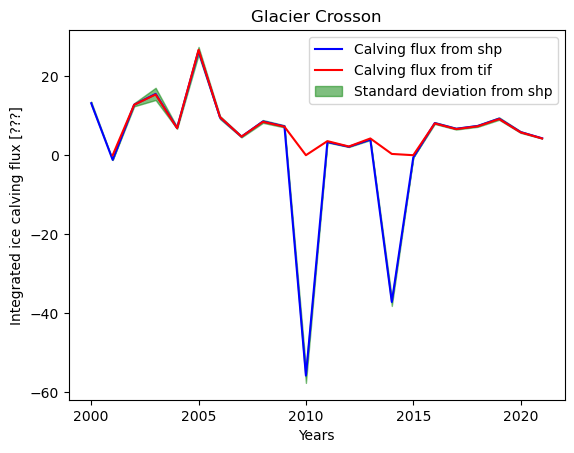

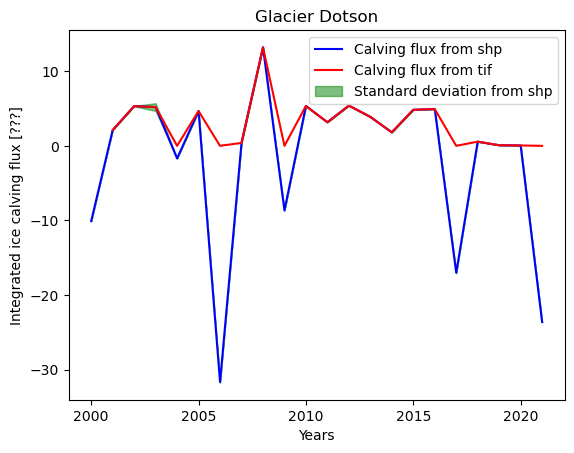

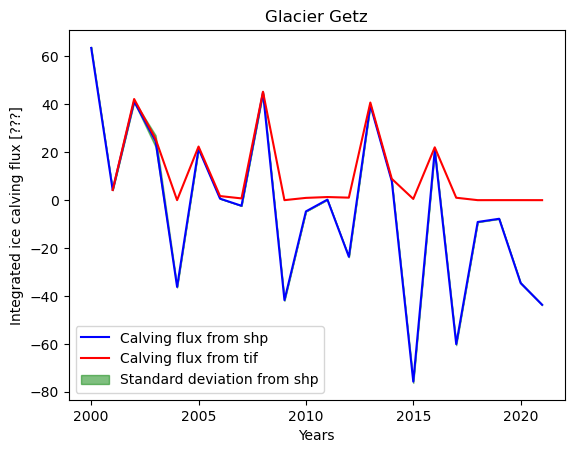

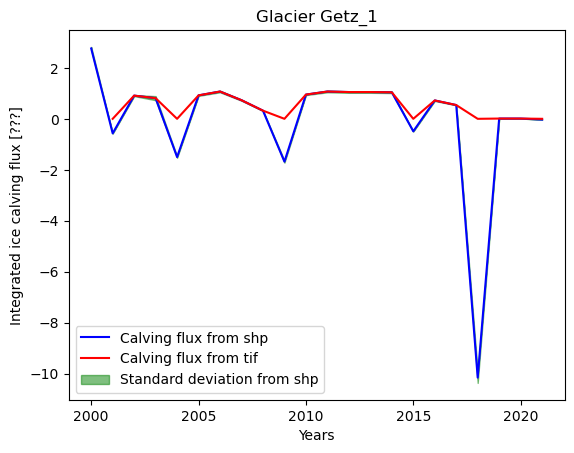

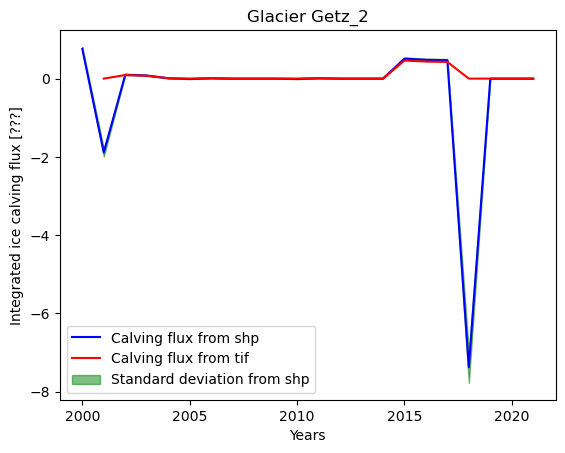

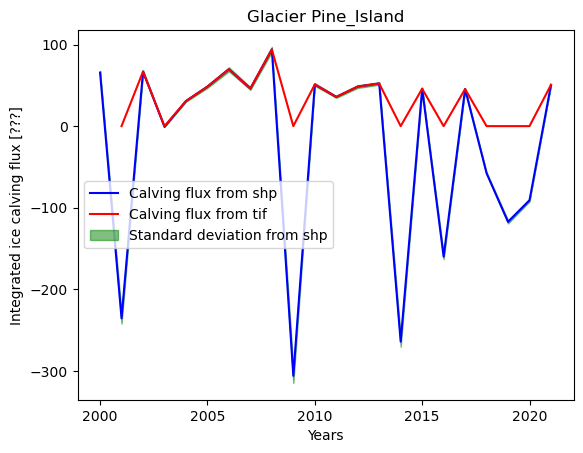

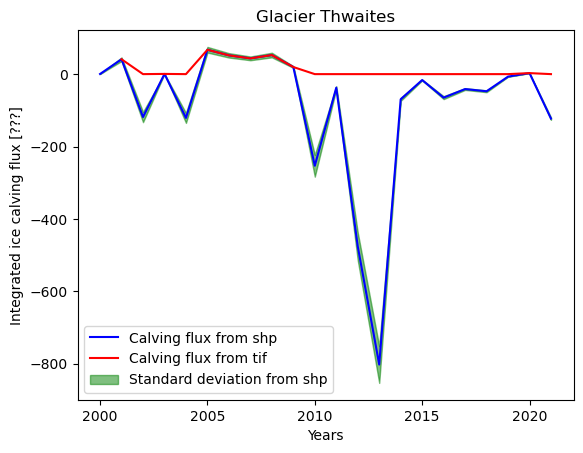

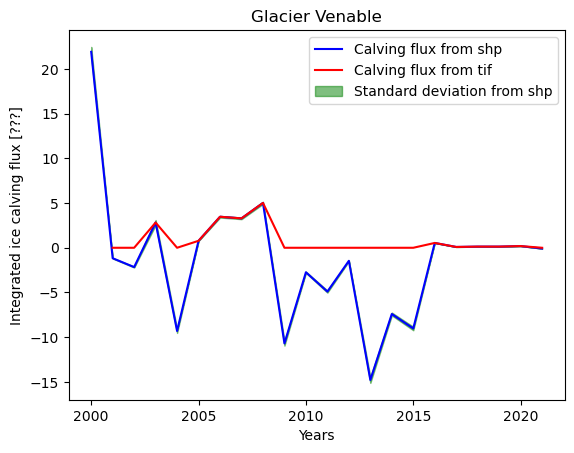

In [47]:
with PdfPages('Interesting_Glaciers.pdf') as pdf:
    for indice in range(0,len(interesting_glaciers)):


        x = np.array(interesting_glaciers_time_series_shp[indice])
        x_sd = np.array(interesting_glaciers_time_series_shp_sd[indice])

        fig =plt.figure()


        plt.plot(years, interesting_glaciers_time_series_shp[indice], label = 'Calving flux from shp', color = 'blue')
        plt.plot(years[1:], interesting_glacier_time_series_tif[indice], label = 'Calving flux from tif', color = 'red')
        plt.fill_between(years, x-x_sd, x+x_sd, alpha = 0.5, label = 'Standard deviation from shp', color = 'green')
        plt.title('Glacier ' +str(interesting_names[indice]))

        plt.xlabel('Years')
        plt.ylabel('Integrated ice calving flux [???]')

        plt.legend()
        pdf.savefig(fig)
 

In [48]:
interesting_glaciers_time_series_shp[0]

array([ 13.16,  -1.18,  12.76,  15.51,   6.91,  26.4 ,   9.53,   4.7 ,
         8.54,   7.3 , -55.77,   3.33,   2.14,   3.94, -37.14,  -0.57,
         8.13,   6.69,   7.4 ,   9.26,   5.85,   4.28])

In [49]:
id_measures_sort = np.argsort(id_measures)
id_measures_sort

array([ 34, 117, 163,  78,  86,  85,  88,  84, 148, 138, 139, 125, 108,
       119, 178, 169,  41,  26,  73, 133,  51,  74,  33, 153, 155, 100,
        93,  54,  63, 141,  92,  36,  89, 129,  47,  21, 128, 123,  42,
       172, 175, 171, 174, 173,  59,  15, 158, 102,  19, 167,  83, 143,
       157,  31, 118, 150,  32,  38,  62,  60,  61,  75,  81, 109, 144,
       147, 127, 170,  64, 132, 131, 113,  40,  66,  24,  58,  22, 151,
        14,  50, 176,  97, 154, 106, 126, 112,  99, 140,  30, 103, 164,
       177,  12, 120, 104, 161, 152,  29, 137,  69, 165, 142, 122,   2,
         3,   4,   5,   6,   0,   1,  90,  28,  37,   9, 156, 107,  17,
        18,  91,  48, 111, 159,  13,  79,  44,  96,  23, 114,  45, 145,
        94,  11,  95,  77, 124,  80,  16,  25,  56, 115, 101,  39,  10,
        35,  72,  49,   7,  98, 136, 168, 166,  52,  82,  46,  70, 105,
       121, 160,  55,  87, 110, 146, 162,  65,  71,  76,  67, 116,  57,
       130,  53,  43,   8, 149,  20,  27,  68, 134, 135])